In [1]:
from web3 import Web3

# Connect to local Ganache blockchain
# IMPORTANT: Check your Ganache port number (7545 or 8545)
ganache_url = "http://127.0.0.1:7545"  # Adjust port if needed
web3 = Web3(Web3.HTTPProvider(ganache_url))

# Test connection
if web3.is_connected():
    print("✅ Connected to Ganache successfully!")
    print(f"🔗 Connected to: {ganache_url}")
    print(f"📊 Latest block: {web3.eth.block_number}")
else:
    print("❌ Connection failed. Ensure Ganache is running.")
    print("🔧 Check if the port number matches your Ganache settings")

✅ Connected to Ganache successfully!
🔗 Connected to: http://127.0.0.1:7545
📊 Latest block: 32


In [2]:
# Milestone 1 Reference

from web3 import Web3
import pandas as pd
import time
from datetime import datetime
import os

print("FROM Week 4 - Milestone 1: Smart Tracking System")

print("Step 1: Loading logistics data from CSV...")
try:
    # Load your actual CSV data
    df = pd.read_csv("logistics_data.csv")
    print("✅ Successfully loaded logistics data!")
    print(f"Number of parcels: {len(df)}")
    
except FileNotFoundError:
    print("❌ CSV file not found!")
    print("📋 SOLUTIONS:")
    print("1. Copy logistics_data.csv to same folder as this notebook")
    print("2. Or run your data generation code first")
    print("3. Or upload the file using Jupyter's Upload button")
    exit()

print("\n" + "="*60)

print("Step 2: Connecting to Ganache...")
ganache_url = "http://127.0.0.1:7545"
web3 = Web3(Web3.HTTPProvider(ganache_url))

if web3.is_connected():
    print("✅ Connected to Ganache successfully!")
    print(f"Connected to blockchain at: {ganache_url}")
    print(f"Latest block number: {web3.eth.block_number}")
else:
    print("❌ Connection failed. Ensure Ganache is running.")
    exit()

# Set default account
web3.eth.default_account = web3.eth.accounts[0]
print(f"Default account: {web3.eth.default_account}")
print(f"Account balance: {web3.from_wei(web3.eth.get_balance(web3.eth.default_account), 'ether')} ETH")

print("\n" + "="*60)


print("Step 3: Processing logistics data...")

def parse_date_string(date_str):
    """Convert your date format to Unix timestamp"""
    try:
        # For now, let's use current time with some variation
        base_time = int(time.time())
        import random
        variation = random.randint(-86400*7, 86400*7)  # ±7 days
        return base_time + variation
    except:
        return int(time.time())

# [Vien] Automatically skip already uploaded parcels using this CSV checker logic
uploaded_count = 0
uploaded_count_path = "uploaded_count.txt"

if os.path.exists(uploaded_count_path):
    with open(uploaded_count_path, "r") as file:
        uploaded_count = int(file.read().strip())

print(f"ℹ️ Skipping first {uploaded_count} parcels (already uploaded)")

# Process remaining parcels
blockchain_data = []
for index, row in df.iloc[uploaded_count:].iterrows():
    departed_timestamp = parse_date_string(row['Date Departed'])
    arrived_timestamp = parse_date_string(row['Date Arrived'])

    if arrived_timestamp <= departed_timestamp:
        arrived_timestamp = departed_timestamp + 86400

    parcel_data = {
        'parcel_id': row['Parcel #'],
        'origin': row['Origin'], 
        'destination': row['Destination'],
        'date_departed': departed_timestamp,
        'date_arrived': arrived_timestamp
    }
    blockchain_data.append(parcel_data)

# [Vien] Save updated count
new_uploaded_count = uploaded_count + len(blockchain_data)
with open(uploaded_count_path, "w") as file:
    file.write(str(new_uploaded_count))

# Show processed data
print("✅ Processed logistics data for blockchain storage:")
for i, data in enumerate(blockchain_data):
    departed_readable = datetime.fromtimestamp(data['date_departed']).strftime('%Y-%m-%d %H:%M')
    arrived_readable = datetime.fromtimestamp(data['date_arrived']).strftime('%Y-%m-%d %H:%M')
    print(f"  {data['parcel_id']}: {data['origin']} → {data['destination']}")
    print(f"    Departed: {departed_readable}, Arrived: {arrived_readable}")

print("\n" + "="*60)

print("Step 4: Connecting to your deployed smart contract...")

# YOUR ACTUAL DEPLOYED CONTRACT ADDRESS
contract_address = "0xa59526bCDfF6D2174A1745b8A443496FD719a4a0"

# YOUR EXACT CONTRACT ABI (FIXED - with proper Python boolean values)
abi = [
    {
        "inputs": [],
        "stateMutability": "nonpayable",
        "type": "constructor"
    },
    {
        "anonymous": False,
        "inputs": [
            {
                "indexed": False,  
                "internalType": "uint256",
                "name": "date_departed",
                "type": "uint256"
            },
            {
                "indexed": False,
                "internalType": "uint256",
                "name": "date_arrived",
                "type": "uint256"
            },
            {
                "indexed": False,
                "internalType": "string",
                "name": "parcel_id",
                "type": "string"
            },
            {
                "indexed": False,
                "internalType": "string",
                "name": "origin",
                "type": "string"
            },
            {
                "indexed": False,
                "internalType": "string",
                "name": "destination",
                "type": "string"
            }
        ],
        "name": "DataStored",
        "type": "event"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            }
        ],
        "name": "markDelivered",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "anonymous": False,
        "inputs": [
            {
                "indexed": False,
                "internalType": "string",
                "name": "parcel_id",
                "type": "string"
            },
            {
                "indexed": False,
                "internalType": "uint256",
                "name": "deliveryTime",
                "type": "uint256"
            }
        ],
        "name": "PackageDelivered",
        "type": "event"
    },
    {
        "anonymous": False,
        "inputs": [
            {
                "indexed": False,
                "internalType": "string",
                "name": "parcel_id",
                "type": "string"
            },
            {
                "indexed": False,
                "internalType": "string",
                "name": "status",
                "type": "string"
            },
            {
                "indexed": False,
                "internalType": "string",
                "name": "location",
                "type": "string"
            }
        ],
        "name": "PackageStatusUpdated",
        "type": "event"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "_origin",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "_destination",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "_dateDeparted",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "_dateArrived",
                "type": "uint256"
            }
        ],
        "name": "storeData",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "_status",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "_location",
                "type": "string"
            }
        ],
        "name": "updatePackageStatus",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "name": "activePackages",
        "outputs": [
            {
                "internalType": "string",
                "name": "",
                "type": "string"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "name": "dataRecords",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "date_departed",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "date_arrived",
                "type": "uint256"
            },
            {
                "internalType": "string",
                "name": "parcel_id",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "origin",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "destination",
                "type": "string"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "getActivePackages",
        "outputs": [
            {
                "internalType": "string[]",
                "name": "",
                "type": "string[]"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "getPackageCount",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            }
        ],
        "name": "getPackageDetails",
        "outputs": [
            {
                "internalType": "string",
                "name": "origin",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "destination",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "dateDeparted",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "dateArrived",
                "type": "uint256"
            },
            {
                "internalType": "string",
                "name": "currentStatus",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "currentLocation",
                "type": "string"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            }
        ],
        "name": "getPackageHistory",
        "outputs": [
            {
                "internalType": "uint256[]",
                "name": "indices",
                "type": "uint256[]"
            },
            {
                "internalType": "uint256",
                "name": "totalRecords",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            }
        ],
        "name": "getPackageStatus",
        "outputs": [
            {
                "internalType": "string",
                "name": "status",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "location",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "lastUpdate",
                "type": "uint256"
            },
            {
                "internalType": "bool",
                "name": "isActive",
                "type": "bool"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "uint256",
                "name": "index",
                "type": "uint256"
            }
        ],
        "name": "getRecord",
        "outputs": [
            {
                "internalType": "string",
                "name": "parcel_id",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "origin",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "destination",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "date_departed",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "date_arrived",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "getTotalRecords",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "MAX_ENTRIES",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "owner",
        "outputs": [
            {
                "internalType": "address",
                "name": "",
                "type": "address"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "_parcelId",
                "type": "string"
            }
        ],
        "name": "packageExists",
        "outputs": [
            {
                "internalType": "bool",
                "name": "",
                "type": "bool"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "name": "packageHistory",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "string",
                "name": "",
                "type": "string"
            }
        ],
        "name": "packageStatus",
        "outputs": [
            {
                "internalType": "string",
                "name": "currentStatus",
                "type": "string"
            },
            {
                "internalType": "string",
                "name": "currentLocation",
                "type": "string"
            },
            {
                "internalType": "uint256",
                "name": "lastUpdate",
                "type": "uint256"
            },
            {
                "internalType": "bool",
                "name": "isActive",
                "type": "bool"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    }
]

# Connect to your deployed smart contract

contract = web3.eth.contract(address=contract_address, abi=abi)
print(f"✅ Connected to deployed contract at: {contract_address}")

print("\n" + "="*60)

print("WEEK 6 : Data Retrieval and Processing")

# Load logistics CSV
df = pd.read_csv('logistics_data.csv')

# Step 1: Convert to datetime
df["date_departed"] = pd.to_datetime(df["Date Departed"], format="%Y-%d-%m %H:%M:%S")
df["date_arrived"] = pd.to_datetime(df["Date Arrived"], format="%Y-%d-%m %H:%M:%S")

# Step 2: Convert datetime to UNIX timestamps
df["date_departed_unix"] = df["date_departed"].astype(int) // 10**9
df["date_arrived_unix"] = df["date_arrived"].astype(int) // 10**9

# Step 3: Push to blockchain
# ⚠️ WARNING: This will re-upload all rows. Avoid running repeatedly.
#for i, row in df.iterrows():
#    tx_hash = contract.functions.storeData(
#        row['Parcel #'],
#        row['Origin'],
#        row['Destination'],
#        int(row["date_departed_unix"]),
#        int(row["date_arrived_unix"])
#    ).transact({'from': web3.eth.accounts[0]})

#    web3.eth.wait_for_transaction_receipt(tx_hash)
#    print(f"✅ Record {i+1} added: {row['Parcel #']}")

# Step 4: Get total records
total_records = contract.functions.getTotalRecords().call()
print(f"Total IoT records stored: {total_records}")

# Step 5: Retrieve data from blockchain
data = []
for i in range(total_records):
    record = contract.functions.getRecord(i).call()
    data.append({
        "parcel_id": record[0],
        "origin": record[1],
        "destination": record[2],
        "date_departed": record[3],
        "date_arrived": record[4]
    })

# Step 6: Convert to DataFrame
df = pd.DataFrame(data)

# Step 7: Convert UNIX back to readable datetime
df["date_departed"] = pd.to_datetime(df["date_departed"], unit="s")
df["date_arrived"] = pd.to_datetime(df["date_arrived"], unit="s")

# Step 8: Save retrieved data to CSV
print(df.head())  # Optional: View sample
df.to_csv("retrieved_data.csv", index=False)
print("✅ Data saved to retrieved_data.csv")

print("\n" + "="*60)

FROM Week 4 - Milestone 1: Smart Tracking System
Step 1: Loading logistics data from CSV...
✅ Successfully loaded logistics data!
Number of parcels: 30

Step 2: Connecting to Ganache...
✅ Connected to Ganache successfully!
Connected to blockchain at: http://127.0.0.1:7545
Latest block number: 32
Default account: 0x656271491De8A9802Ef86c09D7eB3691c75e58aC
Account balance: 99.994590291297982982 ETH

Step 3: Processing logistics data...
ℹ️ Skipping first 30 parcels (already uploaded)
✅ Processed logistics data for blockchain storage:

Step 4: Connecting to your deployed smart contract...
✅ Connected to deployed contract at: 0xa59526bCDfF6D2174A1745b8A443496FD719a4a0

WEEK 6 : Data Retrieval and Processing
Total IoT records stored: 30
  parcel_id       origin destination       date_departed        date_arrived
0  Parcel 1         Cebu   Zamboanga 2025-04-25 09:02:27 2025-05-01 03:51:27
1  Parcel 2        Davao      Taguig 2025-05-05 11:18:27 2025-05-11 08:36:27
2  Parcel 3       Manila    


WEEK 7 : Line Plot of IoT Sensor Readings Over Time
    parcel_id     origin destination       date_departed        date_arrived  \
15  Parcel 16     Iloilo       Davao 2025-06-08 06:56:14 2025-06-16 06:50:14   
5    Parcel 6     Baguio      Iloilo 2025-06-07 11:29:46 2025-06-15 03:24:46   
10  Parcel 11       Cebu      Makati 2025-06-15 04:44:46 2025-06-22 00:00:46   
18  Parcel 19     Baguio      Manila 2025-05-31 08:30:14 2025-06-07 02:25:14   
8    Parcel 9  Zamboanga       Pasig 2025-06-06 09:52:46 2025-06-13 03:46:46   

    travel_duration_hours  
15             191.900000  
5              183.916667  
10             163.266667  
18             161.916667  
8              161.900000  



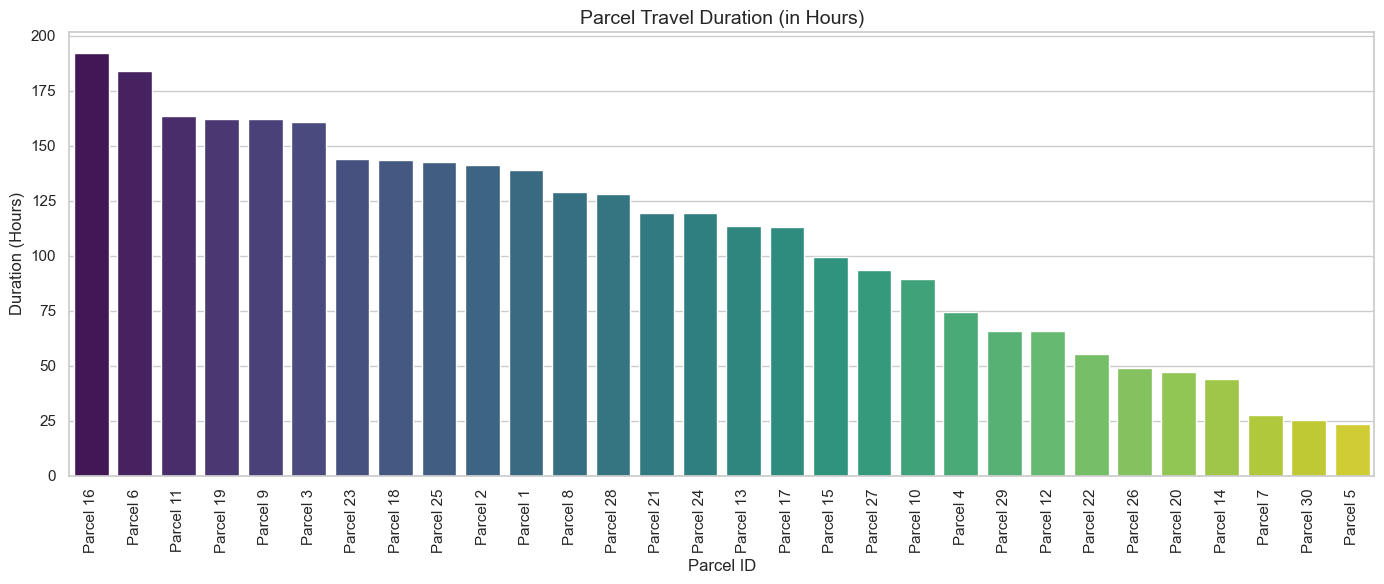

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("WEEK 7 : Line Plot of IoT Sensor Readings Over Time")
# Load cleaned IoT data
df = pd.read_csv('retrieved_data.csv')

# Convert to datetime
df["date_departed"] = pd.to_datetime(df["date_departed"])
df["date_arrived"] = pd.to_datetime(df["date_arrived"])

# Calculate travel duration in hours
df["travel_duration_hours"] = (df["date_arrived"] - df["date_departed"]).dt.total_seconds() / 3600

# Sort parcels by duration for a clearer plot
df = df.sort_values("travel_duration_hours", ascending=False)

# Set visualization style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x="parcel_id", y="travel_duration_hours", hue="parcel_id", data=df, palette="viridis", legend=False)

plt.title("Parcel Travel Duration (in Hours)", fontsize=14)
plt.xlabel("Parcel ID", fontsize=12)
plt.ylabel("Duration (Hours)", fontsize=12)
plt.xticks(rotation=90)

# Display first 5 rows to verify
print(df.head())

# Sort by travel duration, descending, and take top 5
df_subset = df.sort_values("travel_duration_hours", ascending=False).head(5)
print("\n" + "="*60)

plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import random

print("\n" + "="*60)
# Load existing logistics data
df = pd.read_csv("logistics_data.csv")

# Generate RFID tag and verification status
df["RFID Tag"] = ["RFID-" + str(random.randint(10000, 99999)) for _ in range(len(df))]
df["Verified"] = [random.choice(["Yes", "No"]) for _ in range(len(df))]

# Save updated CSV
df.to_csv("logistics_data.csv", index=False)

print("✅ RFID data added to logistics_data.csv")
print(df.head())  # Show preview

print("\n" + "="*60)


✅ RFID data added to logistics_data.csv
   Parcel #       Origin Destination        Date Departed  \
0  Parcel 1         Cebu   Zamboanga  2025-25-04 09:02:27   
1  Parcel 2        Davao      Taguig  2025-05-05 11:18:27   
2  Parcel 3       Manila      Makati  2025-01-05 08:38:27   
3  Parcel 4         Cebu      Baguio  2025-07-05 04:32:27   
4  Parcel 5  Quezon City      Taguig  2025-12-04 10:34:27   

          Date Arrived    RFID Tag Verified  
0  2025-01-05 03:51:27  RFID-71176      Yes  
1  2025-11-05 08:36:27  RFID-21137       No  
2  2025-08-05 01:29:27  RFID-11087       No  
3  2025-10-05 07:03:27  RFID-83221      Yes  
4  2025-13-04 10:11:27  RFID-69826      Yes  



   Parcel #       Origin Destination        Date Departed  \
0  Parcel 1         Cebu   Zamboanga  2025-25-04 09:02:27   
1  Parcel 2        Davao      Taguig  2025-05-05 11:18:27   
2  Parcel 3       Manila      Makati  2025-01-05 08:38:27   
3  Parcel 4         Cebu      Baguio  2025-07-05 04:32:27   
4  Parcel 5  Quezon City      Taguig  2025-12-04 10:34:27   

          Date Arrived    RFID Tag Verified       date_departed  \
0  2025-01-05 03:51:27  RFID-71176      Yes 2025-04-25 09:02:27   
1  2025-11-05 08:36:27  RFID-21137       No 2025-05-05 11:18:27   
2  2025-08-05 01:29:27  RFID-11087       No 2025-05-01 08:38:27   
3  2025-10-05 07:03:27  RFID-83221      Yes 2025-05-07 04:32:27   
4  2025-13-04 10:11:27  RFID-69826      Yes 2025-04-12 10:34:27   

         date_arrived  travel_duration_hours  
0 2025-05-01 03:51:27             138.816667  
1 2025-05-11 08:36:27             141.300000  
2 2025-05-08 01:29:27             160.850000  
3 2025-05-10 07:03:27              74.5166

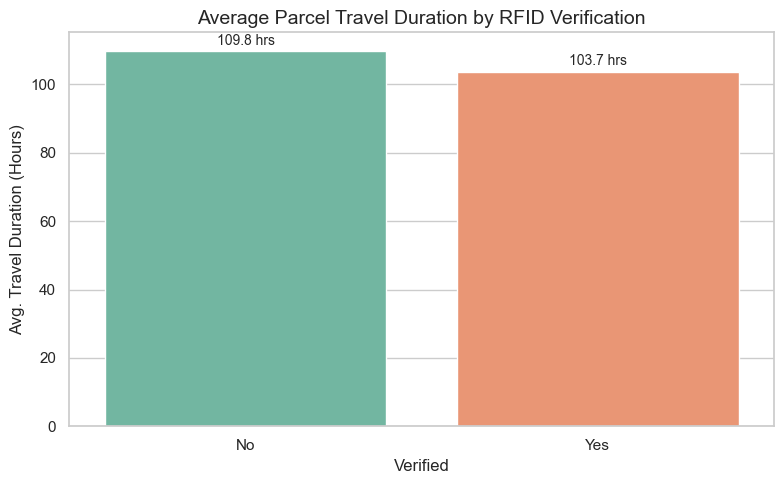

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
df = pd.read_csv("logistics_data.csv")

# Parse dates (make sure they're in correct format)
datetime_format = "%Y-%d-%m %H:%M:%S"
df["date_departed"] = pd.to_datetime(df["Date Departed"], format=datetime_format, errors='coerce')
df["date_arrived"] = pd.to_datetime(df["Date Arrived"], format=datetime_format, errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=["date_departed", "date_arrived"], inplace=True)

# Calculate travel duration in hours
df["travel_duration_hours"] = (df["date_arrived"] - df["date_departed"]).dt.total_seconds() / 3600

# Group by verification status
avg_duration = df.groupby("Verified")["travel_duration_hours"].mean().reset_index()

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x="Verified", y="travel_duration_hours", hue = "Verified", data=avg_duration, palette="Set2", legend=False)

# Add labels
for i, row in avg_duration.iterrows():
    plt.text(i, row["travel_duration_hours"] + 1, f"{row['travel_duration_hours']:.1f} hrs", 
             ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Average Parcel Travel Duration by RFID Verification", fontsize=14)
plt.xlabel("Verified", fontsize=12)
plt.ylabel("Avg. Travel Duration (Hours)", fontsize=12)

# Display first 5 rows to verify
print(df.head())

# Sort by travel duration, descending, and take top 5
df_subset = df.sort_values("travel_duration_hours", ascending=False).head(5)
print("\n" + "="*60)

plt.tight_layout()
plt.show()

   Parcel #       Origin Destination        Date Departed  \
0  Parcel 1         Cebu   Zamboanga  2025-25-04 09:02:27   
1  Parcel 2        Davao      Taguig  2025-05-05 11:18:27   
2  Parcel 3       Manila      Makati  2025-01-05 08:38:27   
3  Parcel 4         Cebu      Baguio  2025-07-05 04:32:27   
4  Parcel 5  Quezon City      Taguig  2025-12-04 10:34:27   

          Date Arrived    RFID Tag Verified       date_departed  \
0  2025-01-05 03:51:27  RFID-71176      Yes 2025-04-25 09:02:27   
1  2025-11-05 08:36:27  RFID-21137       No 2025-05-05 11:18:27   
2  2025-08-05 01:29:27  RFID-11087       No 2025-05-01 08:38:27   
3  2025-10-05 07:03:27  RFID-83221      Yes 2025-05-07 04:32:27   
4  2025-13-04 10:11:27  RFID-69826      Yes 2025-04-12 10:34:27   

         date_arrived  travel_duration_hours  
0 2025-05-01 03:51:27             138.816667  
1 2025-05-11 08:36:27             141.300000  
2 2025-05-08 01:29:27             160.850000  
3 2025-05-10 07:03:27              74.5166

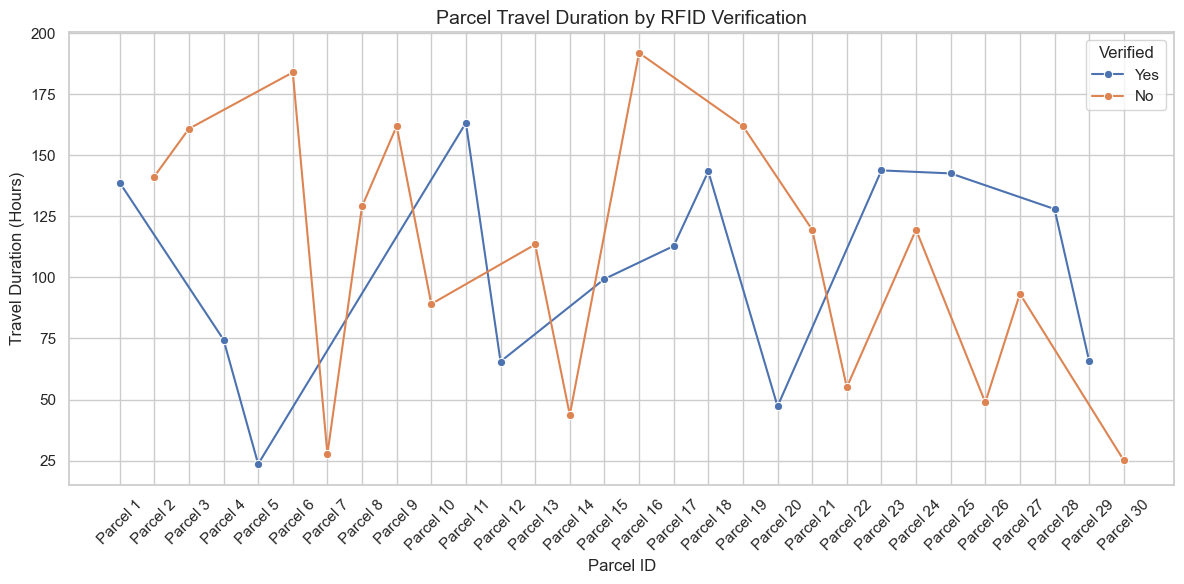

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
df = pd.read_csv("logistics_data.csv")

# Parse dates (correct your format: %Y-%d-%m is year-day-month)
datetime_format = "%Y-%d-%m %H:%M:%S"
df["date_departed"] = pd.to_datetime(df["Date Departed"], format=datetime_format, errors='coerce')
df["date_arrived"] = pd.to_datetime(df["Date Arrived"], format=datetime_format, errors='coerce')

# Drop invalid/missing dates
df.dropna(subset=["date_departed", "date_arrived"], inplace=True)

# Calculate travel duration in hours
df["travel_duration_hours"] = (df["date_arrived"] - df["date_departed"]).dt.total_seconds() / 3600

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create line plot
sns.lineplot(data=df, x="Parcel #", y="travel_duration_hours", hue="Verified", marker="o")

# Improve readability
plt.xticks(rotation=45)
plt.title("Parcel Travel Duration by RFID Verification", fontsize=14)
plt.xlabel("Parcel ID", fontsize=12)
plt.ylabel("Travel Duration (Hours)", fontsize=12)
plt.legend(title="Verified")

# Display first 5 rows to verify
print(df.head())

# Sort by travel duration, descending, and take top 5
df_subset = df.sort_values("travel_duration_hours", ascending=False).head(5)
print("\n" + "="*60)

plt.tight_layout()
plt.show()

     Parcel #    Origin Destination        Date Departed         Date Arrived  \
0    Parcel 1      Cebu   Zamboanga  2025-25-04 09:02:27  2025-01-05 03:51:27   
9   Parcel 10    Cavite        Cebu  2025-03-06 10:10:46  2025-07-06 03:17:46   
10  Parcel 11      Cebu      Makati  2025-15-06 04:44:46  2025-22-06 00:00:46   
11  Parcel 12     Davao        Cebu  2025-04-06 07:04:46  2025-07-06 00:38:46   
12  Parcel 13  Caloocan      Baguio  2025-21-05 08:48:46  2025-26-05 02:17:46   

      RFID Tag Verified       date_departed        date_arrived  \
0   RFID-71176      Yes 2025-04-25 09:02:27 2025-05-01 03:51:27   
9   RFID-32817       No 2025-06-03 10:10:46 2025-06-07 03:17:46   
10  RFID-34353      Yes 2025-06-15 04:44:46 2025-06-22 00:00:46   
11  RFID-33754      Yes 2025-06-04 07:04:46 2025-06-07 00:38:46   
12  RFID-25010       No 2025-05-21 08:48:46 2025-05-26 02:17:46   

    travel_duration_hours  
0              138.816667  
9               89.116667  
10             163.266667 

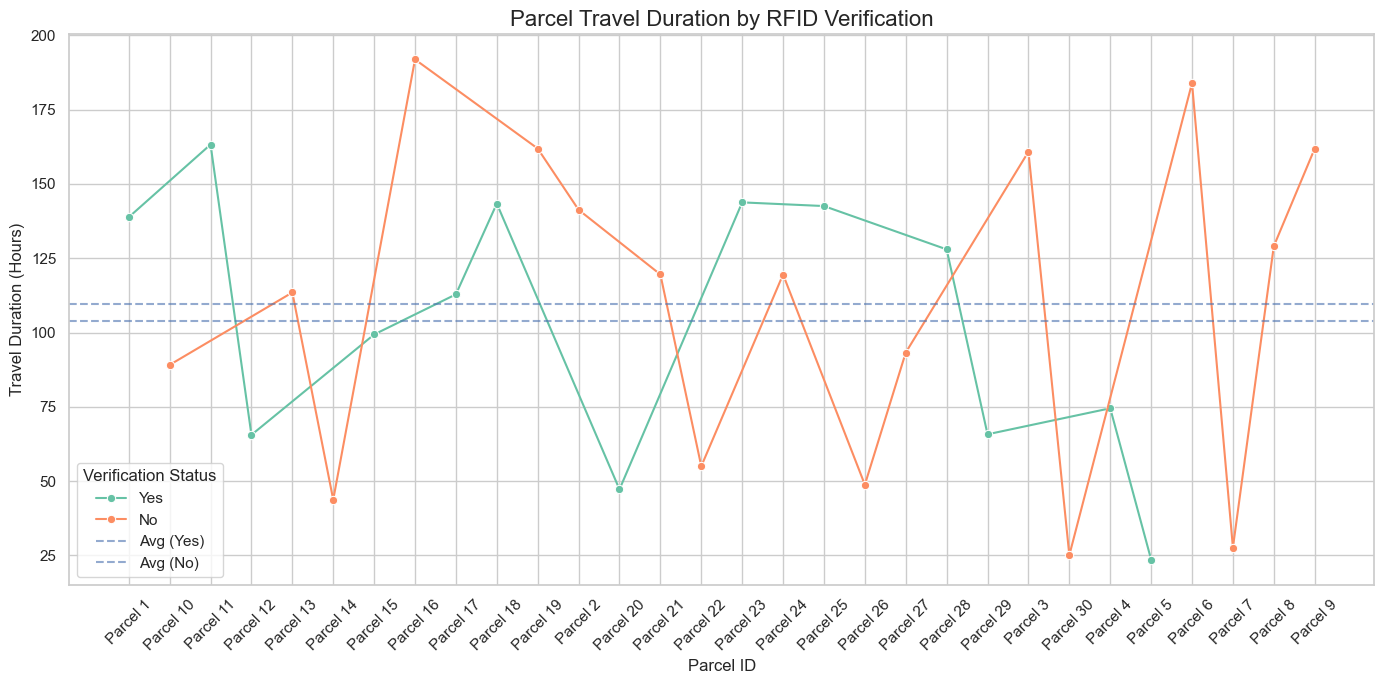

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
df = pd.read_csv("logistics_data.csv")

# Parse date columns
datetime_format = "%Y-%d-%m %H:%M:%S"
df["date_departed"] = pd.to_datetime(df["Date Departed"], format=datetime_format, errors='coerce')
df["date_arrived"] = pd.to_datetime(df["Date Arrived"], format=datetime_format, errors='coerce')

# Drop invalid or missing dates
df.dropna(subset=["date_departed", "date_arrived"], inplace=True)

# Compute travel duration
df["travel_duration_hours"] = (df["date_arrived"] - df["date_departed"]).dt.total_seconds() / 3600

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Sort parcels for cleaner X-axis
df = df.sort_values("Parcel #")

# Plot line chart with markers
sns.lineplot(
    data=df, 
    x="Parcel #", 
    y="travel_duration_hours", 
    hue="Verified", 
    marker="o", 
    palette="Set2"
)

# Add average lines for each group (Yes / No)
for status in df["Verified"].unique():
    avg = df[df["Verified"] == status]["travel_duration_hours"].mean()
    plt.axhline(avg, linestyle='--', label=f"Avg ({status})", alpha=0.6)

# Final touches
plt.xticks(rotation=45)
plt.title("Parcel Travel Duration by RFID Verification", fontsize=16)
plt.xlabel("Parcel ID", fontsize=12)
plt.ylabel("Travel Duration (Hours)", fontsize=12)
plt.legend(title="Verification Status")

# Display first 5 rows to verify
print(df.head())

# Sort by travel duration, descending, and take top 5
df_subset = df.sort_values("travel_duration_hours", ascending=False).head(5)
print("\n" + "="*60)

plt.tight_layout()
plt.show()